In [1]:

import numpy as np
import pandas as pd
import numba as nb

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from IPython.display import clear_output



In [2]:

df_train = pd.read_csv('./input/train/sign_mnist_train.csv')
df_test = pd.read_csv('./input/test/sign_mnist_test.csv')




In [3]:

# only hand gestures from 0 to 10, X represents all the pixels (from  col 1 to 1784)
X_train, y_train = df_train[df_train['label'] < 10].values[:,1:], df_train[df_train['label'] < 10].values[:,0]
X_test, y_test = df_test[df_test['label'] < 10].values[:,1:], df_test[df_test['label'] < 10].values[:,0]



In [4]:


# Normalize
X_train, X_test = X_train / 255., X_test / 255

# Format (#, 1, 28, 28)
X_train, X_test = X_train.reshape(X_train.shape[0], 1, 28, 28), X_test.reshape(X_test.shape[0], 1, 28, 28)



In [5]:


@nb.jit(nopython=True)
def maxpool(X, f, s):
    (l, w, w) = X.shape
    pool = np.zeros((l, (w-f)//s+1,(w-f)//s+1))
    for jj in range(0,l):
        for i in range(0, w, s):
            for j in range(0, w, s):
                pool[jj,i//2,j//2] = np.max(X[jj,i:i+f,j:j+f])
    return pool




@nb.jit(nopython=True)
def relu(x):
    return x * (x > 0)

@nb.jit(nopython=True)
def drelu(x):
    return 1. * (x > 0)


def softmax_cost(out,y):
    eout = np.exp(out, dtype=np.float64)
    probs = eout/sum(eout)

    p = sum(y*probs)
    cost = -np.log(p)
    return cost, probs





In [6]:
@nb.jit(nopython=True)
def forward(image, theta, sizes):
    filt1, filt2, bias1, bias2, theta3, bias3 = theta
    l, w, f, l1, l2, w1, w2 = sizes

    conv1 = np.zeros((l1,w1,w1))
    conv2 = np.zeros((l2,w2,w2))

    for jj in range(0,l1):
        for x in range(0,w1):
            for y in range(0,w1):
                conv1[jj,x,y] = np.sum(image[:,x:x+f,y:y+f]*filt1[jj])+bias1[jj]
    conv1 = relu(conv1)

    for jj in range(0,l2):
        for x in range(0,w2):
            for y in range(0,w2):
                conv2[jj,x,y] = np.sum(conv1[:,x:x+f,y:y+f]*filt2[jj])+bias2[jj]
    conv2 = relu(conv2)

    ## Pooled layer with 2*2 size and stride 2,2
    pooled_layer = maxpool(conv2, 2, 2)	

    fc1 = pooled_layer.reshape(((w2//2)*(w2//2)*l2,1))

    out = theta3.dot(fc1) + bias3

    return conv1, conv2, pooled_layer, fc1, out

In [7]:
# get the highest (index) value of the arrays
def get_nanargmax(conv2, sizes):

    def nanargmax(a):
        idx = np.argmax(a, axis=None)
        multi_idx = np.unravel_index(idx, a.shape)
        if np.isnan(a[multi_idx]):
            nan_count = np.sum(np.isnan(a))
            idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
            multi_idx = np.unravel_index(idx, a.shape)
        return multi_idx

    l, w, f, l1, l2, w1, w2 = sizes
    nanarg = np.zeros((l2, w2, w2, 2))

    for jj in range(0, l2):
        for i in range(0, w2, 2):
            for j in range(0, w2, 2):
                (a,b) = nanargmax(conv2[jj,i:i+2,j:j+2])
                nanarg[jj, i, j, 0] = a
                nanarg[jj, i, j, 1] = b

    return nanarg

In [8]:


@nb.jit(nopython=True)
def init_grads(sizes):
    l, w, f, l1, l2, w1, w2 = sizes
    
    dconv2 = np.zeros((l2, w2, w2))
    dconv1 = np.zeros((l1, w1, w1))

    dfilt2 = np.zeros((l2, l1,f,f))
    dbias2 = np.zeros((l2, ))

    dfilt1 = np.zeros((l1,l,f,f))
    dbias1 = np.zeros((l1,))
    
    return dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2



In [9]:
@nb.jit(nopython=True)
def backward(image, label, theta, delta, probs, nanarg, sizes):
    l, w, f, l1, l2, w1, w2 = sizes
    conv1, conv2, pooled_layer, fc1, out = delta
    dconv1, dconv2, dfilt1, dfilt2, dbias1, dbias2 = init_grads(sizes)

    dout = probs - label
    dtheta3 = dout.dot(fc1.T)
    dbias3 = dout

    dfc1 = dtheta3.T.dot(dout)
    dpool = dfc1.T.reshape((l2, w2//2, w2//2))

    for jj in range(0, l2):
        for i in range(0, w2, 2):
            for j in range(0, w2, 2):
                a = int(nanarg[jj , i, j, 0])
                b = int(nanarg[jj , i, j, 1])
                dconv2[jj,i+a,j+b] = dpool[jj,i//2,j//2]

    dconv2 = dconv2 * drelu(conv2)

    for jj in range(0,l2):
        for x in range(0,w2):
            for y in range(0,w2):
                dfilt2[jj]+=dconv2[jj,x,y]*conv1[:,x:x+f,y:y+f]
                dconv1[:,x:x+f,y:y+f]+=dconv2[jj,x,y]*filt2[jj]
        dbias2[jj] = np.sum(dconv2[jj])

    dconv1 = dconv1 * drelu(conv1)

    for jj in range(0,l1):
        for x in range(0,w1):
            for y in range(0,w1):
                dfilt1[jj]+=dconv1[jj,x,y]*image[:,x:x+f,y:y+f]

        dbias1[jj] = np.sum(dconv1[jj])

    return dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3

In [10]:
def init_grads_velocity(filt1, filt2, bias1, bias2, theta3, bias3):
    dfilt1 = np.zeros((len(filt1), filt1[0].shape[0], filt1[0].shape[1], filt1[0].shape[2]))
    dbias1 = np.zeros((len(filt1),))
    v1 = np.zeros((len(filt1), filt1[0].shape[0], filt1[0].shape[1], filt1[0].shape[2]))
    bv1 = np.zeros((len(filt1),))

    dfilt2 = np.zeros((len(filt2), filt2[0].shape[0], filt2[0].shape[1], filt2[0].shape[2]))
    dbias2 = np.zeros((len(filt2),))
    v2 = np.zeros((len(filt2), filt2[0].shape[0], filt2[0].shape[1], filt2[0].shape[2]))
    bv2 = np.zeros((len(filt2),))

    dtheta3 = np.zeros(theta3.shape)
    dbias3 = np.zeros(bias3.shape)
    v3 = np.zeros(theta3.shape)
    bv3 = np.zeros(bias3.shape)

    return dfilt1, dfilt2, dtheta3, dbias1, dbias2, dbias3, v1, v2, v3, bv1, bv2, bv3



def batches(X, y, size):
    batches = []
    
    for idx in np.array_split(np.arange(len(X)), len(X) / size):
        X_batch = X[idx]
        y_batch = y[idx]
        batches.append((X_batch, y_batch))
    
    return batches


In [11]:


NUM_OUTPUT = 10
LEARNING_RATE = 0.0001
IMG_WIDTH = 28
IMG_DEPTH = 1
FILTER_SIZE=5
NUM_FILT1 = 8
NUM_FILT2 = 8
BATCH_SIZE = 8
NUM_EPOCHS = 3000
MU = 0.95
NUM_IMAGES = int(len(X_train) / BATCH_SIZE)


np.random.seed(3424242)

scale = 1.0
stddev = scale * np.sqrt(1./FILTER_SIZE*FILTER_SIZE*IMG_DEPTH)

filt1 =np.random.normal(loc = 0, scale=stddev, size=((NUM_FILT1,IMG_DEPTH,FILTER_SIZE,FILTER_SIZE)))
bias1 = np.zeros((NUM_FILT1,))
filt2 =np.random.normal(loc = 0, scale=stddev, size=((NUM_FILT2,NUM_FILT1,FILTER_SIZE,FILTER_SIZE)))
bias2 = np.zeros((NUM_FILT2,))

w1 = IMG_WIDTH-FILTER_SIZE+1
w2 = w1-FILTER_SIZE+1

theta3 = np.random.rand(NUM_OUTPUT, (w2//2)*(w2//2)*NUM_FILT2) * 0.01
bias3 = np.zeros((NUM_OUTPUT,1))

theta = filt1, filt2, bias1, bias2, theta3, bias3



(l,w,w) = X_train[0].shape
(l1,f,f) = filt2[0].shape
l2 = len(filt2)
w1 = w-f+1
w2 = w1-f+1

sizes = l, w, f, l1, l2, w1, w2





accuracies = []
costs = []





for epoch in range(NUM_EPOCHS):


    filt1, filt2, bias1, bias2, theta3, bias3 = theta
    dfilt1, dfilt2, dtheta3, dbias1, dbias2, dbias3, v1, v2, v3, bv1, bv2, bv3 = init_grads_velocity(filt1, filt2, bias1, bias2, theta3, bias3)
    
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    minibatches = batches(X_train, y_train, BATCH_SIZE)
    
    idx = np.random.randint(0, len(minibatches))
    X_batch, y_batch = minibatches[idx]

    acc = 0
    cost_epoch = 0

    for i in range(0, BATCH_SIZE):

        label = np.zeros((theta3.shape[0],1))
        label[int(y_batch[i]),0] = 1

        delta = forward(X_batch[i], theta, sizes)

        cost, probs = softmax_cost(delta[-1], label)
        if np.argmax(probs) == np.argmax(label):
            acc += 1
        cost_epoch += cost
            
        nanarg = get_nanargmax(delta[1], sizes)
        dfilt1, dfilt2, dbias1, dbias2, dtheta3, dbias3 = backward(X_batch[i], label, theta, delta, probs, nanarg, sizes)

        dfilt2 += dfilt2
        dbias2 += dbias2

        dfilt1 += dfilt1
        dbias1 += dbias1

        dtheta3 += dtheta3
        dbias3 += dbias3
        
    accuracies.append(acc)
    costs.append(cost_epoch/BATCH_SIZE)

    v1 = MU * v1 - LEARNING_RATE * dfilt1 / BATCH_SIZE
    filt1 += v1
    bv1 = MU * bv1 - LEARNING_RATE * dbias1 / BATCH_SIZE
    bias1 += bv1

    v2 = MU * v2 - LEARNING_RATE * dfilt2 / BATCH_SIZE
    filt2 += v2
    bv2 = MU * bv2 - LEARNING_RATE * dbias2 / BATCH_SIZE
    bias2 += bv2

    v3 = MU * v3 - LEARNING_RATE * dtheta3 / BATCH_SIZE
    theta3 += v3
    bv3 = MU * bv3 - LEARNING_RATE * dbias3 / BATCH_SIZE
    bias3 += bv3

    theta = filt1, filt2, bias1, bias2, theta3, bias3

    if(epoch % 150 == 0):
        print("Epoch:{0:3d}, Accuracy:{1:0.3f}, Cost:{2:3.3f}".format(epoch, acc/BATCH_SIZE, costs[-1][0]))




Epoch:  0, Accuracy:0.125, Cost:2.499
Epoch:150, Accuracy:0.250, Cost:2.286
Epoch:300, Accuracy:0.375, Cost:2.238
Epoch:450, Accuracy:0.500, Cost:2.265
Epoch:600, Accuracy:0.500, Cost:2.281
Epoch:750, Accuracy:0.250, Cost:2.281
Epoch:900, Accuracy:0.500, Cost:2.269
Epoch:1050, Accuracy:0.250, Cost:2.248
Epoch:1200, Accuracy:0.375, Cost:2.226
Epoch:1350, Accuracy:0.250, Cost:2.266
Epoch:1500, Accuracy:0.125, Cost:2.269
Epoch:1650, Accuracy:0.375, Cost:2.281
Epoch:1800, Accuracy:0.625, Cost:2.261
Epoch:1950, Accuracy:0.375, Cost:2.204
Epoch:2100, Accuracy:0.375, Cost:2.225
Epoch:2250, Accuracy:0.375, Cost:2.239
Epoch:2400, Accuracy:0.625, Cost:2.168
Epoch:2550, Accuracy:0.250, Cost:2.261
Epoch:2700, Accuracy:0.500, Cost:2.229
Epoch:2850, Accuracy:0.250, Cost:2.275


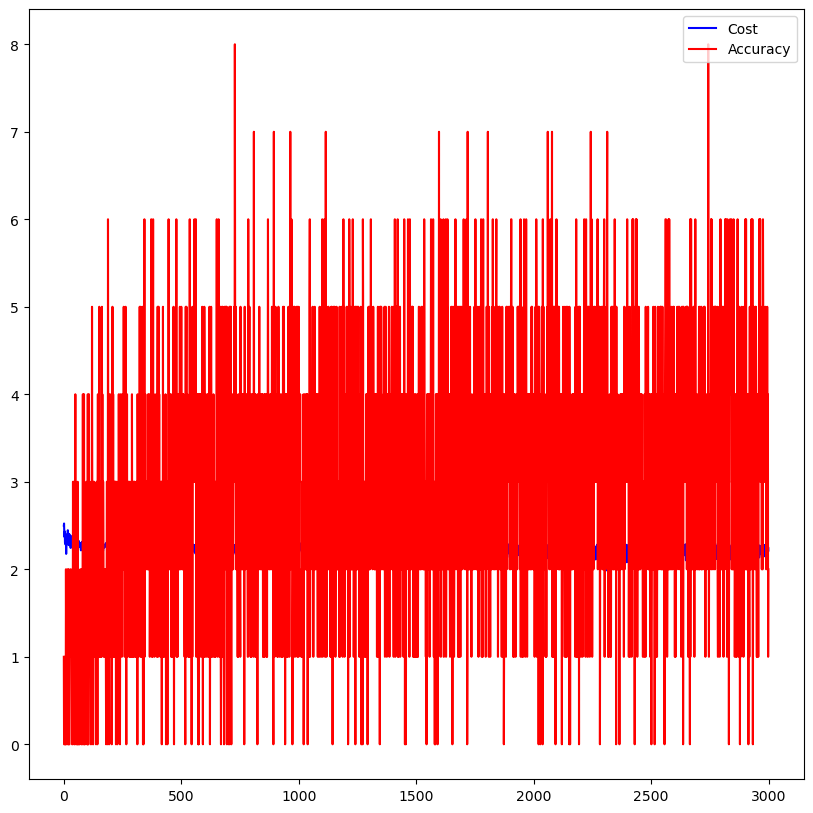

In [12]:
costs = np.array(costs)
accuracies = np.array(accuracies)

plt.figure(figsize=(10,10))
plt.plot(costs, "-b", label="Cost")
plt.plot(accuracies, "-r", label="Accuracy")
plt.legend(loc="upper right")
plt.show()






In [13]:
def accuracy(X_test, y_test):
    acc = 0
    for i in range(len(X_test)):
        delta = forward(X_test[i], theta, sizes)
        cost, probs = softmax_cost(delta[-1], label)
        
        if np.argmax(probs) == y_test[i]:
            acc += 1
    print("Test accuracy:{0:2.2f}%".format(acc/len(X_test) * 100))


accuracy(X_test, y_test)

Test accuracy:32.60%
